# DISPLAY MAPS

## Display sea ice statistics maps in the Weddell Sea using .nc files
- Read netCDF files for the sea ice statistics
- Draw sea ice statistics maps in the Weddell Sea

Credited by Younghyun Koo (kooala317@gmail.com)

## (1) Import necessary libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import numpy as np
import h5py

import matplotlib.pylab as plt
from math import *
import time
import pandas as pd
import datetime as dt
from tqdm import tqdm
import geopandas
import json
from datetime import datetime, timedelta
from scipy import stats

from scipy.ndimage import gaussian_filter1d

import pickle

%load_ext autoreload
%autoreload 2
from functions_floes import *

In [56]:
%matplotlib notebook

In [34]:
import ee

In [35]:
# Authenticate
ee.Authenticate()

# Initialize with your own project.
ee.Initialize(project = "ee-kooala317")

In [36]:
import geemap

### Necessary functions

In [38]:
def determine_iceberg(df, ib_mask):
    # INPUT:
    # freeboard: along-track freeboard measurement of ICESat-2 ATL10 track
    # ib_mask: along-track initial iceberg mask (0: sea ice; 1: iceberg)
    # seg_dist: along-track distance of ICESat-2 ATL10 track (unit: meters)
    # nprof: number of points in normalized profiles

    seg_dist = df['seg_x'].values
    freeboard = df['fb'].values
    seg_len = df['seg_len'].values
    
    delta_dist = np.append(0, np.diff(seg_dist))
    ib_mask2 = ib_mask.copy()

    ib_cnt_st = -1
    ib_cnt_en = -1

    df_ib = pd.DataFrame({})

    c = 0
    for i in range(1, len(freeboard)):
        # print(i)

        if (ib_mask[i] == True) and (ib_mask[i-1] != True):
            ib_cnt_st = i
            ib_cnt_en = i

        elif (ib_mask[i] == True) and (ib_mask[i-1] == True):
            ib_cnt_en = i

        elif (ib_mask[i] != True) and (ib_mask[i-1] == True):
            
            if abs(seg_dist[ib_cnt_en] - seg_dist[ib_cnt_st]) < 100:
                # print(seg_dist[ib_cnt_en] - seg_dist[ib_cnt_st], ib_cnt_en, ib_cnt_st)
                ib_mask2[ib_cnt_st:ib_cnt_en+1] = False
            else:
                
                df_ib.loc[c, "lat"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'lat'].median()
                df_ib.loc[c, "lon"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'lon'].median()
                df_ib.loc[c, "seg_x"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'seg_x'].median()
                df_ib.loc[c, "id_st"] = ib_cnt_st
                df_ib.loc[c, "id_en"] = ib_cnt_en
                df_ib.loc[c, "fb_mean"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'fb'].mean()
                df_ib.loc[c, "fb_max"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'fb'].max()
                df_ib.loc[c, "fb_min"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'fb'].min()
                df_ib.loc[c, "fb_std"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'fb'].std()
                df_ib.loc[c, "width"] = abs(seg_dist[ib_cnt_st] - seg_dist[ib_cnt_en])
                c += 1
        else:
            pass
                
    return ib_mask2, df_ib

def combine_icebergs(df, df_ib, ib_mask):
    
    for c in range(1, len(df_ib)):
        fb_btw = df.loc[int(df_ib.loc[c-1, "id_en"]): int(df_ib.loc[c, "id_st"])+1, "fb"]
        # print(c, int(df_ib.loc[c-1, "id_en"]), int(df_ib.loc[c, "id_st"])+1, fb_btw > 1.0)
        x1 = df.loc[int(df_ib.loc[c-1, "id_en"]), "seg_x"]
        x2 = df.loc[int(df_ib.loc[c, "id_st"]), "seg_x"]
        if all(fb_btw > 1.0) & (abs(x1-x2) < 1000):
            
            ib_cnt_st = df_ib.loc[c-1, "id_st"]
            ib_cnt_en = df_ib.loc[c, "id_en"]

            # print(c, ib_cnt_st, ib_cnt_en)
            
            df_ib.loc[c, "lat"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'lat'].median()
            df_ib.loc[c, "lon"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'lon'].median()
            df_ib.loc[c, "seg_x"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'seg_x'].median()
            df_ib.loc[c, "id_st"] = ib_cnt_st
            df_ib.loc[c, "id_en"] = ib_cnt_en
            df_ib.loc[c, "fb_mean"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'fb'].mean()
            df_ib.loc[c, "fb_max"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'fb'].max()
            df_ib.loc[c, "fb_min"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'fb'].min()
            df_ib.loc[c, "fb_std"] = df.loc[ib_cnt_st:ib_cnt_en+1, 'fb'].std()
            df_ib.loc[c, "width"] = abs(df.loc[ib_cnt_st, 'seg_x'] - df.loc[ib_cnt_en, 'seg_x'])

            df_ib = df_ib.drop(c-1)
            
    df_ib = df_ib.reset_index(drop = True)
    
    for c in range(0, len(df_ib)):
        if df_ib.loc[c, "width"] < 200:
            ib_mask[int(df_ib.loc[c, "id_st"]): int(df_ib.loc[c, "id_en"])+1] = 0
            df_ib = df_ib.drop(c)
        else:
            ib_mask[int(df_ib.loc[c, "id_st"]): int(df_ib.loc[c, "id_en"])+1] = 1
            
    df_ib = df_ib.reset_index(drop = True)
    
    return df_ib, ib_mask

### Find icebergs for all ATL10 files in the Weddell Sea

In [3]:
region = "Weddell"

if region == "Weddell":
    bbox = [-62, -77.6, -15, -60]
elif region == "Ross":
    bbox = [158, -79, -145, -65]

# if region == "west":
#     bbox = [-65, -73, -45, -62]
# elif region == "south":
#     bbox = [-65, -77.6, -15, -73]
# elif region == "entire":
#     bbox = [-65, -77.6, -15, -62]

for year in [2019]:
    if region == "Weddell":
        path = "D:\\Floes\\ATL10\\ATL10-02_{0}*.h5".format(int(year))
    elif region == "Ross":
        path = "D:\\Ross\\ATL10_h5\\ATL10-02_{0}*.h5".format(int(year))
        
    files = glob.glob(path)    

    for th_fb in [0.8]: #[0.9, 1.0]:
        for th_sigma in [0.02]:
            for th_std in [0.1]:
    
                first = True
                print(f"Region: {region};  Year: {year};  Freeboard: {th_fb}; Sigma: {th_sigma}; Std: {th_std}")
                
                for k, filename in tqdm(enumerate(files)):
                
                    df_raw = read_ATL10(filename, bbox)
                    date_str = filename.split("ATL10-02_")[1][:8]               
    
                    if len(df_raw) > 0:
                        strong_beams = pd.unique(df_raw['beam'])
                        
                        for beam in strong_beams:
                
                            df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
                
                            ib_mask2, df_ib = determine_iceberg(df, th_fb = th_fb, th_sigma = th_sigma, th_std = th_std)
                            df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)
                            df_ib2['filename'] = os.path.basename(filename)
                            df_ib2['beam'] = beam
                            # df_ib2['beam_num'] = beam_num
                            df_ib2['year'] = date_str[:4]
                            df_ib2['month'] = date_str[4:6]
                            df_ib2['day'] = date_str[6:8]
                    
                            if first:
                                df_ib_all = df_ib2
                                first = False
                            else:
                                df_ib_all = pd.concat([df_ib_all, df_ib2]).reset_index(drop = True)
                        
                df_ib_all.to_csv(f"D:\\Floes\\icebergs\\Icebergs_{region}_{year}_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv")
                print(year, " - Number of icebergs: ", len(df_ib_all))

Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.02; Std: 0.1


1169it [39:08,  2.01s/it]


2019  - Number of icebergs:  2853
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.02; Std: 0.08


1169it [37:46,  1.94s/it]


2019  - Number of icebergs:  2174
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.02; Std: 0.06


1169it [39:39,  2.04s/it]


2019  - Number of icebergs:  1533
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.02; Std: 0.04


1169it [36:05,  1.85s/it]


2019  - Number of icebergs:  761
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.018; Std: 0.1


1169it [37:35,  1.93s/it]


2019  - Number of icebergs:  2536
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.018; Std: 0.08


1169it [35:57,  1.85s/it]


2019  - Number of icebergs:  2025
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.018; Std: 0.06


1169it [37:17,  1.91s/it]


2019  - Number of icebergs:  1455
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.018; Std: 0.04


1169it [38:25,  1.97s/it]


2019  - Number of icebergs:  715
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.016; Std: 0.1


1169it [40:41,  2.09s/it]


2019  - Number of icebergs:  2002
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.016; Std: 0.08


1169it [36:23,  1.87s/it]


2019  - Number of icebergs:  1707
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.016; Std: 0.06


1169it [38:26,  1.97s/it]


2019  - Number of icebergs:  1268
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.016; Std: 0.04


1169it [38:18,  1.97s/it]


2019  - Number of icebergs:  640
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.014; Std: 0.1


1169it [38:45,  1.99s/it]


2019  - Number of icebergs:  1256
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.014; Std: 0.08


1169it [38:52,  2.00s/it]


2019  - Number of icebergs:  1129
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.014; Std: 0.06


1169it [40:09,  2.06s/it]


2019  - Number of icebergs:  889
Region: Weddell;  Year: 2019;  Freeboard: 0.9; Sigma: 0.014; Std: 0.04


1169it [38:12,  1.96s/it]


2019  - Number of icebergs:  422


#### Ross Sea

In [3]:
region = "Ross"
bbox = [160, -80, -150, -60] # Ross Sea

for year in [2019, 2020, 2021, 2022, 2023]:
    
    if region == "Weddell":
        path = "D:\\Floes\\ATL10\\ATL10-02_{0}*.h5".format(int(year))
    elif region == "Ross":
        path = "D:\\Ross\\ATL10_h5\\ATL10-02_{0}*.h5".format(int(year))
        
    files = glob.glob(path)    

    for th_fb in [0.8]: #[0.9, 1.0]:
        for th_sigma in [0.02]:
            for th_std in [0.1]:
    
                first = True
                print(f"Region: {region};  Year: {year};  Freeboard: {th_fb}; Sigma: {th_sigma}; Std: {th_std}")
                
                for k, filename in tqdm(enumerate(files)):
                
                    df_raw = read_ATL10(filename, bbox)
                    date_str = filename.split("ATL10-02_")[1][:8]               
    
                    if len(df_raw) > 0:
                        strong_beams = pd.unique(df_raw['beam'])
                        
                        for beam in strong_beams:
                
                            df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
                
                            ib_mask2, df_ib = determine_iceberg(df, th_fb = th_fb, th_sigma = th_sigma, th_std = th_std)
                            df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)
                            df_ib2['filename'] = os.path.basename(filename)
                            df_ib2['beam'] = beam
                            # df_ib2['beam_num'] = beam_num
                            df_ib2['year'] = date_str[:4]
                            df_ib2['month'] = date_str[4:6]
                            df_ib2['day'] = date_str[6:8]
                    
                            if first:
                                df_ib_all = df_ib2
                                first = False
                            else:
                                df_ib_all = pd.concat([df_ib_all, df_ib2]).reset_index(drop = True)
                        
                df_ib_all.to_csv(f"D:\\Floes\\icebergs\\Icebergs_{region}_{year}_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv")
                print(year, " - Number of icebergs: ", len(df_ib_all))

Region: Ross;  Year: 2019;  Freeboard: 0.8; Sigma: 0.02; Std: 0.1


1307it [34:40,  1.59s/it]


2019  - Number of icebergs:  2849
Region: Ross;  Year: 2020;  Freeboard: 0.8; Sigma: 0.02; Std: 0.1


1470it [39:02,  1.59s/it]


2020  - Number of icebergs:  3174
Region: Ross;  Year: 2021;  Freeboard: 0.8; Sigma: 0.02; Std: 0.1


1508it [39:42,  1.58s/it]


2021  - Number of icebergs:  2372
Region: Ross;  Year: 2022;  Freeboard: 0.8; Sigma: 0.02; Std: 0.1


1373it [36:35,  1.60s/it]


2022  - Number of icebergs:  1795
Region: Ross;  Year: 2023;  Freeboard: 0.8; Sigma: 0.02; Std: 0.1


1356it [31:12,  1.38s/it]


2023  - Number of icebergs:  1989


## Accuracy assessment

In [13]:
year = 2019
th_fb = 0.8
th_sigma = 0.02
th_std = 0.1
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_Weddell_2019_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)

bbox = [-62, -77.6, -15, -60]

In [14]:
df_all.head(5)

,filename,beam,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,2019,1,6,-74.601063,-58.051172,971075.657943,40355.0,40442.0,3.377639,3.622471,2.905646,0.168068,503.735962
1,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,2019,1,6,-74.698224,-58.105407,982039.091091,41938.0,42028.0,3.714575,4.115487,3.518111,0.135430,511.050415
2,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,2019,1,6,-74.592652,-58.161481,974062.928286,32840.0,32881.0,2.964939,3.092570,2.726331,0.098351,315.999573
3,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,2019,1,6,-74.691081,-58.217136,985171.929850,34140.0,34726.0,3.709296,4.193796,2.850458,0.273257,4318.933594
4,ATL10-02_20190106142608_01400201_006_02.h5,gt1l,2019,1,6,-76.181892,-53.830495,527.990014,50.0,145.0,2.217020,2.620863,1.873965,0.240494,531.039185


In [15]:
df_count = df_all.groupby(["filename", "beam"]).sum()
files = df_count.sort_values(by = "width", ascending = False).loc[:, ['lat']].head(30).index.unique().sort_values()

In [16]:
files

MultiIndex([('ATL10-02_20190205233644_06040201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190310110421_11000201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190310110421_11000201_006_02.h5', 'gt2l'),
            ('ATL10-02_20190310110421_11000201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt2l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190314215603_11680201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190502085018_05210301_006_02.h5', 'gt1l'),
            ('ATL10-02_20190522190837_08330301_006_02.h5', 'gt1l'),
            ('ATL10-02_20190522190837_08330301_006_02.h5', 'gt2l'),
            ('ATL10-02_20190522190837_08330301_006_02.h5', 'gt3l'),
            ('ATL10-02_20190530185156_09550301_006_02.h5', 'gt1l'),
            ('ATL10-02_20190621061857_12830301_006_02.h5', 'gt1l'),
            ('ATL10-02_20190621061857_12830301_0

In [17]:
## Convert to Shapefiles
for filename, beam in files[:]:
    with h5py.File("D:\\Floes\\ATL10\\" + filename, 'r') as f:
        # print(filename)
        # Check the orbit orientation
        orient = f['orbit_info/sc_orient'][0]
        strong_beams = []
    
        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]
    
        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 10)
    
        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]
    
        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
        fb_std = pd.Series(fb).rolling(3, center = True).std().values
    
        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb,
                           'fb_std': fb_std, 'ph_rate': ph_rate, 'sigma': sigma})
    
        ib_mask2, df_ib = determine_iceberg(df, th_fb, th_sigma, th_std)
        df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2)
        df['ib_mask'] = ib_mask3.astype(int)
    
        shpname = os.path.basename(filename).replace(".h5", "_"+beam+".shp")
        folder = f"D:\\Floes\\icebergs\\shpfiles_detection_fb{th_fb}"
        if os.path.exists(folder) == False:
            os.mkdir(folder)
        outfile = f"{folder}\\{shpname}"
        convertshp(df, outfile)
    
    print(filename, beam, sum(ib_mask3), len(df))

print("DONE!")

ATL10-02_20190205233644_06040201_006_02.h5 gt3l 3541 29995
ATL10-02_20190310110421_11000201_006_02.h5 gt1l 6865 116720
ATL10-02_20190310110421_11000201_006_02.h5 gt2l 4639 94662
ATL10-02_20190310110421_11000201_006_02.h5 gt3l 6850 119204
ATL10-02_20190310220423_11070201_006_02.h5 gt1l 9657 121127
ATL10-02_20190310220423_11070201_006_02.h5 gt2l 8552 95995
ATL10-02_20190310220423_11070201_006_02.h5 gt3l 10787 120212
ATL10-02_20190314215603_11680201_006_02.h5 gt1l 3396 90850
ATL10-02_20190502085018_05210301_006_02.h5 gt1l 3662 99124
ATL10-02_20190522190837_08330301_006_02.h5 gt1l 6986 114694
ATL10-02_20190522190837_08330301_006_02.h5 gt2l 2983 82699
ATL10-02_20190522190837_08330301_006_02.h5 gt3l 5716 113362
ATL10-02_20190530185156_09550301_006_02.h5 gt1l 6614 119340
ATL10-02_20190621061857_12830301_006_02.h5 gt1l 3915 101291
ATL10-02_20190621061857_12830301_006_02.h5 gt2l 2814 87544
ATL10-02_20190621061857_12830301_006_02.h5 gt3l 4250 84821
ATL10-02_20190727160357_04520401_006_02.h5 gt3l

In [11]:
fb_mode = np.zeros(np.shape(fb))
ridge = np.zeros(np.shape(fb))
sample_ndx = np.zeros(np.shape(fb))

# # Calculate modal freeboard ==============================
for c, i in enumerate(np.unique(refsur_ndx)):
    part = (refsur_ndx == i)
    x_min = np.min(seg_x[part])
    x_max = np.max(seg_x[part])
    sample_ndx[part] = i*10 + (seg_x[part] - x_min)//(10000/3)
    # sample_ndx[part] = c

In [14]:
for i in np.unique(sample_ndx):                
    subndx = (sample_ndx == i)
    subdata = fb[subndx]

np.unique(sample_ndx)

array([140., 141., 142., 150., 151., 152., 160., 161., 162., 170., 171.,
       172., 180., 181., 182., 190., 191., 192., 200., 201., 202., 210.,
       211., 212., 220., 221., 222., 230., 231., 232., 240., 241., 242.,
       250., 251., 252., 260., 261., 262., 270., 271., 272., 310., 311.,
       312., 320., 321., 322., 330., 331., 332., 340., 341., 342., 350.,
       351., 352., 360., 361., 362., 370., 371., 372., 380., 381., 382.,
       390., 391., 392., 400., 401., 402., 410., 411., 412., 420., 421.,
       422., 430., 431., 432., 440., 441., 442., 450., 451., 452., 460.,
       461., 462., 470., 471., 472., 480., 481., 482., 490., 491., 492.,
       500., 501., 502., 510., 511., 512., 520., 521., 522., 530., 531.,
       532., 540., 541., 542., 550., 551., 552., 560., 561., 562., 570.,
       571., 572., 580., 581., 582., 590., 591., 592., 600., 601., 602.,
       610., 611., 612., 620., 621., 622., 630., 631., 632., 640., 641.,
       642., 650., 651., 652., 660., 661., 662., 67

952.0

## Draw profiles

In [141]:
n = 28
filename = "D:\\Floes\\ATL10\\" + files[n][0]
beam = files[n][1]
# beam_nums = df_all.loc[df_all['filename'] == files[n], "beam_num"].unique()
print(filename, beam)

D:\Floes\ATL10\ATL10-02_20191108232735_06580501_006_01.h5 gt1r


In [144]:
th_fb = 0.8
th_sigma = 0.02
th_std = 0.1

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation

    df_raw = read_ATL10(filename, bbox)
    df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
    # df['fb_mode'] = smooth_line(df['fb_mode'].values, df['seg_x'].values, 5000) #gaussian_filter1d(df['fb_mode'], 100)

    # th_fb2 = np.where(df['fb_mode']+0.6 > th_fb, df['fb_mode']+0.6, th_fb)
    ib_mask2, df_ib = determine_iceberg(df, th_fb, th_sigma, th_std)
    df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb)
    df['ib_mask'] = ib_mask3.astype(int)

    # shpname = os.path.basename(filename).replace(".h5", "_"+beam+".shp")
    # outfile = f"D:\\Floes\\icebergs\\shpfiles_detection_fb{th_fb}\\{shpname}"
    # convertshp(df, outfile)

print(filename)

D:\Floes\ATL10\ATL10-02_20191108232735_06580501_006_01.h5


In [108]:
df.head(5)

,beam,lat,lon,seg_x,seg_len,fb,ph_rate,sigma,stype,refsur_ndx,sample_ndx,fb_std,fb_mode,ridge,ib_mask
0,gt2l,-77.002175,-46.878214,0.000000,23.285349,0.282080,4.088235,0.017853,1,70,700.0,NaN,0.43,0.0,0
1,gt2l,-77.002045,-46.878315,14.657027,28.945429,0.186841,3.333333,0.015986,1,70,700.0,0.049647,0.43,0.0,0
2,gt2l,-77.001922,-46.878411,28.605473,24.722435,0.210134,3.777778,0.012161,1,70,700.0,0.012617,0.43,0.0,0
3,gt2l,-77.001839,-46.878477,38.072962,23.322559,0.206891,4.147059,0.012102,1,70,700.0,0.004896,0.43,0.0,0
4,gt2l,-77.001742,-46.878552,49.031729,24.045261,0.200510,4.028572,0.012198,1,70,700.0,0.020441,0.43,0.0,0


D:\Floes\ATL10\ATL10-02_20191108232735_06580501_006_01.h5 24 2174


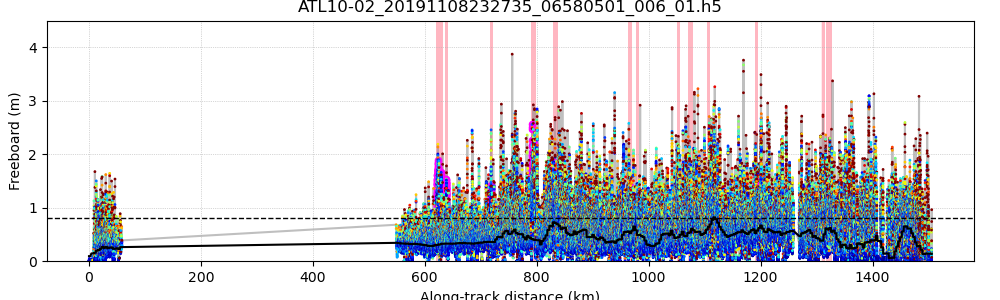

In [145]:
%matplotlib widget
print(filename, len(df_ib2), sum(ib_mask3))
fig, ax = plt.subplots(1,1, figsize = (10, 3))
fig.tight_layout()

# pm = ax.pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(df['seg_x']/1000, df['fb'], c="gray", zorder=1, alpha = 0.5)
ax.plot(df['seg_x']/1000, df['fb_mode'], c="k", zorder=10)
sc = ax.scatter(df['seg_x']/1000, df['fb'], c=df['fb_std'], s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby

# sc = ax.scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax.scatter(df['seg_x'][ib_mask3]/1000, df['fb'][ib_mask3], s= 20, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax.scatter(seg_x[ib_mask3]/1000 - seg_min, fb[ib_mask3]*0 + 4.2, s= 20, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(th_fb, ls = "--", lw = 1, c="k", zorder=2)
# ax.plot(df['seg_x']/1000, th_fb, c="k")
ax.vlines(df['seg_x'][ib_mask3]/1000, 0, 5, color="lightpink", zorder = 0, alpha = 0.5, lw = 1)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");

ax.set_ylim(0, 4.5);

ax.set_xlabel("Along-track distance (km)")

plt.show()
# plt.close()

## Figures for Floes paper

In [102]:
year = 2019
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{region}_{year}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)

bbox = [-62, -77.6, -15, -60]

In [103]:
df_all.head(5)

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,2,2019,1,6,-74.696045,-58.104172,2.840756e+07,41937.0,41939.0,3.286645,4.139675,0.803014,1.655887,2962.105518
1,ATL10-02_20190128125318_04750201_006_02.h5,gt3l,2,2019,1,28,-77.048003,-45.411343,3.153924e+07,4889.0,4891.0,2.815334,3.749400,0.073831,1.827727,364.688665
2,ATL10-02_20190201124501_05360201_006_02.h5,gt1l,2,2019,2,1,-77.457868,-46.145792,3.149398e+07,2.0,218.0,2.208784,4.795080,1.040448,0.706147,1262.228372
3,ATL10-02_20190201124501_05360201_006_02.h5,gt3l,2,2019,2,1,-77.478857,-45.845838,3.149040e+07,103.0,169.0,1.534435,1.986665,1.192618,0.179018,357.599200
4,ATL10-02_20190201234503_05430201_006_02.h5,gt1l,2,2019,2,1,-76.910373,-47.072810,2.865782e+07,86533.0,86596.0,3.581594,3.901320,3.243701,0.100923,360.053550


In [105]:
df_count = df_all.groupby('filename').count()

In [131]:
files = df_count.sort_values(by = "lat", ascending = False).loc[:, ['beam']].head(12).index.unique().sort_values()

In [133]:
files

Index(['ATL10-02_20190310110421_11000201_006_02.h5',
       'ATL10-02_20190310220423_11070201_006_02.h5',
       'ATL10-02_20190518191658_07720301_006_02.h5',
       'ATL10-02_20190522190837_08330301_006_02.h5',
       'ATL10-02_20190530185156_09550301_006_02.h5',
       'ATL10-02_20190621061857_12830301_006_02.h5',
       'ATL10-02_20190731155540_05130401_006_02.h5',
       'ATL10-02_20190902142326_10160401_006_02.h5',
       'ATL10-02_20190906141506_10770401_006_02.h5',
       'ATL10-02_20191005125113_01320501_006_02.h5',
       'ATL10-02_20191019003453_03380501_006_02.h5',
       'ATL10-02_20191227084738_00100601_006_01.h5'],
      dtype='object', name='filename')

In [70]:
n = 8
filename = "D:\\Floes\\ATL10\\" + files[n]
beam_nums = df_all.loc[df_all['filename'] == files[n], "beam_num"].unique()
print(filename, beam_nums)

D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5 [0]


In [71]:
filename = "D:\\Floes\\ATL10\\" + files[n]
beam_num = 0

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 10)

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
        fb_std = pd.Series(fb).rolling(3, center = True).std().values

        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb, 'ph_rate': ph_rate, 'sigma': sigma})

        ib_mask = (fb > 1.0) & (sigma < 0.03) & (fb_std < 0.1)
        ib_mask2, df_ib = determine_iceberg(df, ib_mask)
        df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2)

print(filename)

D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5


In [72]:
df_ib2

,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,-67.854187,-53.472409,2.763767e+07,56237.0,56342.0,1.552851,2.13494,1.013791,0.272408,652.142155


D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


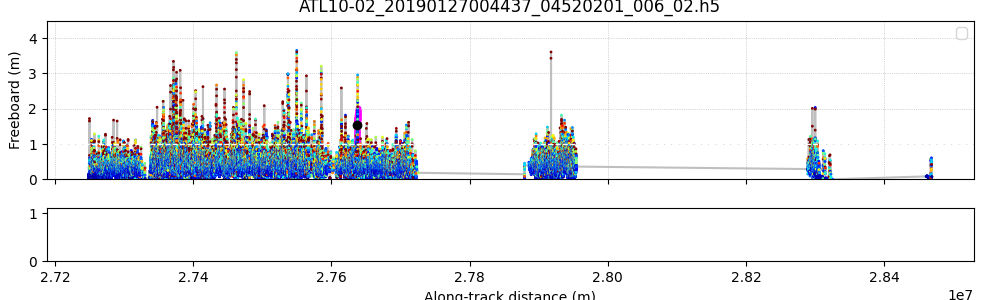

In [75]:
%matplotlib widget
print(filename)
fig, ax = plt.subplots(2,1, figsize = (10, 3), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax[0].scatter(seg_x[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

ax[0].errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
# fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax[0].set_ylim(0, 4.5);

# a = np.sum(ratio[5:, ], axis = 0)
# ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

## Figures for iceberg detection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


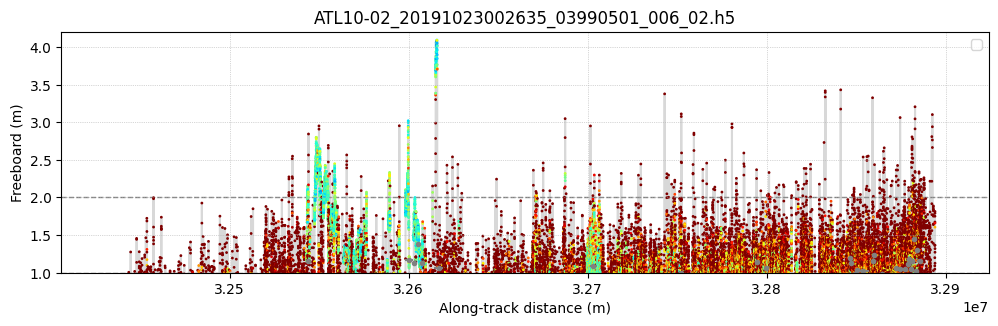

In [153]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 3))
fig.tight_layout()
ax.plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
# ax.scatter(seg_x, fb, c=bck, s= 1, cmap = "jet", vmax = 500000) # background rate
# ax.scatter(seg_x, fb, c=asr, s= 1, cmap = "jet", vmax = 0.7, vmin = 0.6) # surface reflectance
ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
# ax.scatter(seg_x, fb, c=ph_rate, s= 1, cmap = "jet", vmax = 10, vmin = 5) # photon rate
# plt.scatter(floe_loc0, fb_mean0, s = 1, c = "k")
ax.errorbar(floe_loc0, fb_mean0, xerr = floe_len0/2, fmt ='.', color = "gray")
# ax.scatter(lead_pos0, lead_pos0*0, c= "k", s= 20, label = "leads")
ax.legend()
ax.axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax.axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)
ax.set_xlabel("Along-track distance (m)")
ax.set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax.set_xlim(32540*1000, 32560*1000);
ax.set_ylim(1, 4.2);

plt.show()
# plt.close()

In [532]:
seg_x.max() - seg_x.min()

space = 1000
space_fb = 0.2

bin_seg_x = np.arange(np.floor(seg_x.min()/space)*space, np.floor(seg_x.max()/space)*space + space, space)
bin_fb = np.arange(0,5+space_fb, space_fb)

In [533]:
xx, yy = np.meshgrid(bin_seg_x + space/2, bin_fb + space_fb/2)
count = np.zeros(xx.shape)
ratio = np.zeros(xx.shape)
filter = np.zeros(xx.shape)

for i in range(0, xx.shape[0]-1):
    for j in range(0, xx.shape[1]-1):
        count[i, j] = np.sum((seg_x >= bin_seg_x[j]) & (seg_x < bin_seg_x[j+1]) & (fb >= bin_fb[i]) & (fb < bin_fb[i+1]))

ratio = count / np.sum(count, axis=0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


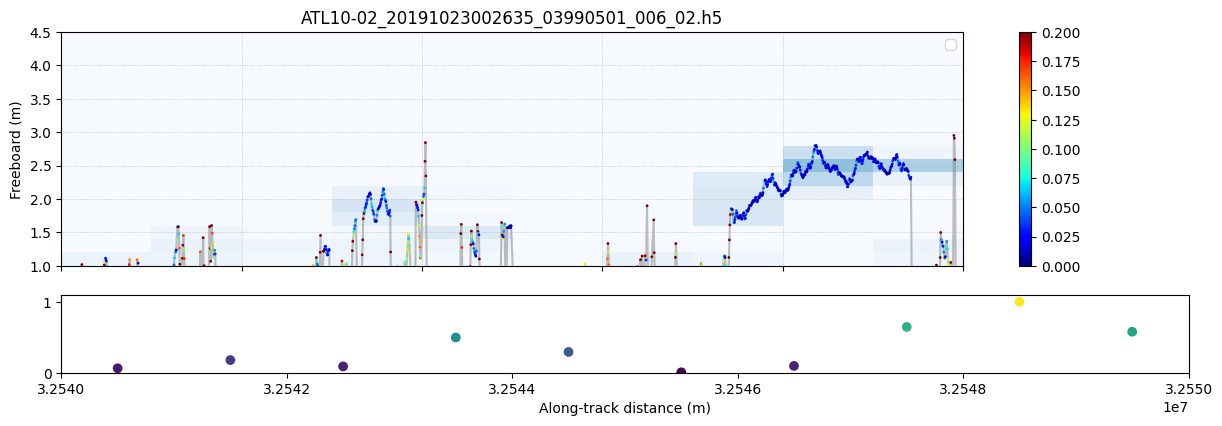

In [255]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(2,1, figsize = (12, 4), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 5) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
ax[0].set_xlim(32540*1000, 32550*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
ax[0].set_ylim(1, 4.5);

a = np.sum(ratio[5:, ], axis = 0)
ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191005125113_01320501_006_02.h5


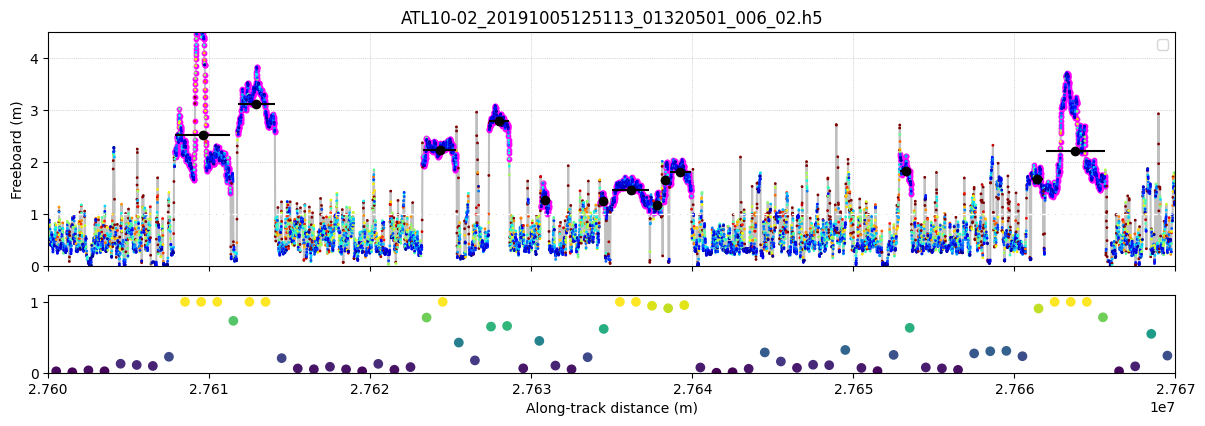

In [651]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(2,1, figsize = (12, 4), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax[0].scatter(seg_x[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

ax[0].errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
# fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

ax[0].set_xlim(27600*1000, 27670*1000);
ax[0].set_ylim(0, 4.5);

a = np.sum(ratio[5:, ], axis = 0)
ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

In [642]:
ib_mask3

array([False, False, False, ..., False, False, False])

In [641]:
df_ib2

,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
8,-66.758148,-55.075900,2.751517e+07,66545.0,66591.0,1.774768,1.986350,1.051248,0.171473,307.849823
10,-67.599186,-55.326757,2.760959e+07,75612.0,76136.0,2.517295,4.679867,0.365546,0.924735,3449.202316
11,-67.628813,-55.335948,2.761292e+07,76194.0,76546.0,3.113596,3.825711,2.528698,0.288546,2304.830171
12,-67.730180,-55.367825,2.762431e+07,77882.0,78199.0,2.236157,2.460335,1.843640,0.129044,2079.363266
13,-67.763130,-55.377931,2.762801e+07,78482.0,78671.0,2.781950,3.084039,1.955690,0.153398,1230.300540
14,-67.788493,-55.385646,2.763085e+07,78959.0,79031.0,1.256609,1.600289,0.660537,0.157481,482.430888
15,-67.820366,-55.395375,2.763443e+07,79490.0,79535.0,1.251099,1.403426,0.189387,0.179874,297.256535
16,-67.835922,-55.400106,2.763618e+07,79597.0,79947.0,1.456297,1.714460,1.035936,0.155945,2305.428940
18,-67.850279,-55.404459,2.763779e+07,79984.0,80037.0,1.177688,1.415224,1.009412,0.125481,355.310391
19,-67.855103,-55.405939,2.763833e+07,80069.0,80113.0,1.646357,1.991160,1.235387,0.274014,291.159064


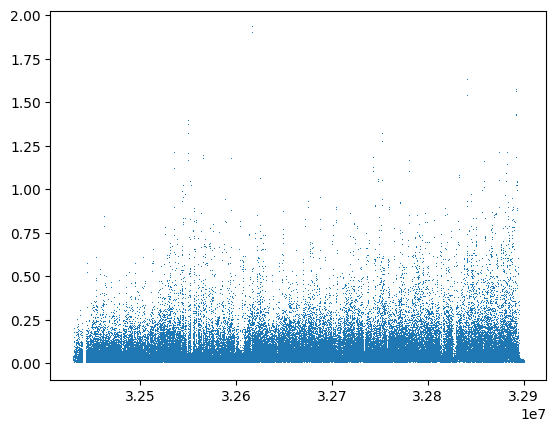

In [189]:
fb_std = pd.Series(fb).rolling(3).std().values
plt.plot(seg_x, fb_std, ',')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


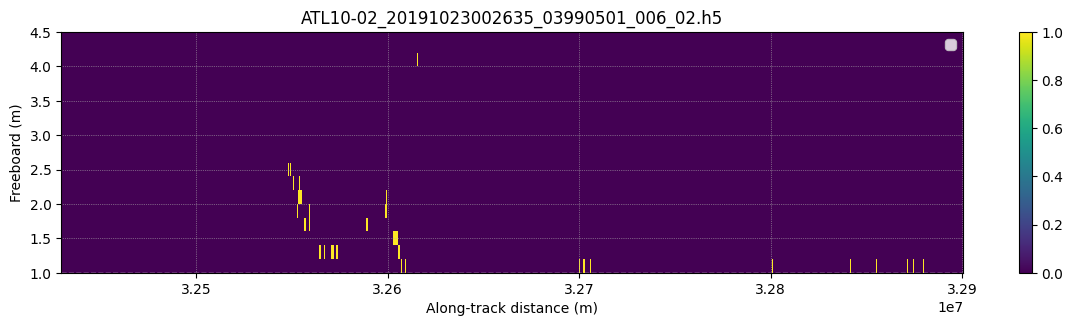

In [182]:
%matplotlib inline

filter[ratio > 0.4] = 1


print(filename)
fig, ax = plt.subplots(1,1, figsize = (12, 3))
fig.tight_layout()
pm = ax.pcolormesh(xx, yy, filter, zorder = 0)
# sc = ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 5) # sigma
fig.colorbar(pm)
ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)
ax.set_xlabel("Along-track distance (m)")
ax.set_ylabel("Freeboard (m)");

# ax.set_xlim(32614*1000, 32617*1000);
# ax.set_xlim(32540*1000, 32560*1000);
# ax.set_xlim(32840*1000, 32895*1000);
ax.set_ylim(1, 4.5);

plt.show()
# plt.close()

In [19]:
with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2])

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        asr = f[beam]['freeboard_segment/heights/asr_25'][idx]
        bck = f[beam]['freeboard_segment/heights/background_r_norm'][idx]
        rms = f[beam]['freeboard_segment/heights/height_segment_rms'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]

        print(f[beam]['freeboard_segment/heights'].keys())

<KeysViewHDF5 ['asr_25', 'backgr_calc', 'backgr_r_200', 'backgr_r_25', 'background_r_norm', 'bsnow_con', 'bsnow_h', 'cloud_flag_asr', 'cloud_flag_atm', 'delta_time', 'height_segment_confidence', 'height_segment_dist2land', 'height_segment_height', 'height_segment_length_seg', 'height_segment_ocdepth', 'height_segment_rms', 'height_segment_sigma', 'height_segment_ssh_flag', 'height_segment_type', 'height_segment_w_gaussian', 'ice_conc_amsr2', 'ice_conc_ssmi', 'latitude', 'layer_flag', 'longitude', 'msw_flag', 'photon_rate', 'podppd_flag']>


In [155]:
X

array([ 3.61268028e-09+0.00000000e+00j,  1.25966509e+03+7.43072867e+04j,
        1.53982402e+03+3.78706580e+04j, ...,
       -3.45859673e+00-4.56488630e-02j, -3.45279132e+00-2.90427881e-02j,
       -3.45105987e+00-5.86040679e-03j])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


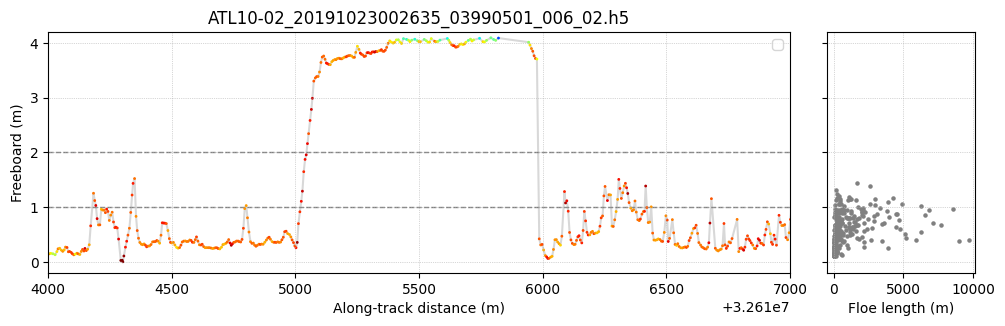

In [160]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,2, figsize = (10, 3), gridspec_kw={'width_ratios': [5, 1]}, sharey = True)
fig.tight_layout()
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
ax[0].plot(year + spots.mean(), spots)
# ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
ax[0].scatter(seg_x, fb, c=ph_rate, s= 1, cmap = "jet", vmax = 10) # photon rate

ax[0].legend()
ax[0].axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax[0].axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_xlabel("Along-track distance (m)")
ax[0].set_ylabel("Freeboard (m)");

ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32598*1000, 32609*1000);
ax[0].set_ylim(-0.2, 4.2);

ax[1].scatter(floe_len0, fb_mean0, s = 5, c = "gray")
ax[1].grid(ls = ":", lw = 0.5)
ax[1].set_xlabel("Floe length (m)")
# ax[1].set_xscale('log')

plt.show()
# plt.close()

In [3]:
year = 2019
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{year}.csv", index_col = 0)

bbox = [-62, -77.6, -15, -60]

In [19]:
df_all.head(5)

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,0,2019,1,6,-74.601091,-58.051187,2.839684e+07,40357.0,40441.0,3.382634,3.622471,2.905646,0.162428,467.942822
1,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,0,2019,1,6,-74.698437,-58.105523,2.840783e+07,41940.0,42035.0,3.659101,4.088406,0.090341,0.389613,1376.631922
2,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,1,2019,1,6,-74.592710,-58.161513,2.839640e+07,32842.0,32881.0,2.973534,3.092570,2.750389,0.092182,273.630694
3,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,1,2019,1,6,-74.691138,-58.217169,2.840750e+07,34142.0,34726.0,3.707140,4.193796,2.539752,0.277467,4100.056202
4,ATL10-02_20190106142608_01400201_006_02.h5,gt1l,0,2019,1,6,-76.182618,-53.830011,3.163831e+07,20.0,145.0,2.378184,3.122895,1.873965,0.362548,675.041457


In [86]:
ib_count = df_all.groupby('filename', as_index = False).count()

In [87]:
ib_count[ib_count["beam"] > 10]

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
11,ATL10-02_20190201234503_05430201_006_02.h5,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
12,ATL10-02_20190205233644_06040201_006_02.h5,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
16,ATL10-02_20190219112019_08100201_006_02.h5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
26,ATL10-02_20190302222103_09850201_006_02.h5,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
29,ATL10-02_20190310110421_11000201_006_02.h5,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,ATL10-02_20191120102817_08330501_006_01.h5,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
290,ATL10-02_20191120230236_08410501_006_01.h5,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
295,ATL10-02_20191124101957_08940501_006_01.h5,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
302,ATL10-02_20191129094557_09700501_006_01.h5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [17]:
filename = "D:\\Floes\\ATL10\\ATL10-02_20190310110421_11000201_006_02.h5"
# filename = "D:\\Floes\\ATL10\\ATL10-02_20191023002635_03990501_006_02.h5"
beam_num = 2

bbox = [-62, -77.6, -15, -60]

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 10)

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
        fb_std = pd.Series(fb).rolling(3, center = True).std().values

        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb,
                           'fb_std': fb_std, 'ph_rate': ph_rate, 'sigma': sigma})

        # ib_mask = (fb > 1.0) & (sigma < 0.03) & (fb_std < 0.1)
        ib_mask2, df_ib = determine_iceberg(df, th_fb = 0.8, th_sigma = 0.02, th_std = 0.1)
        df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)

print(filename)

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


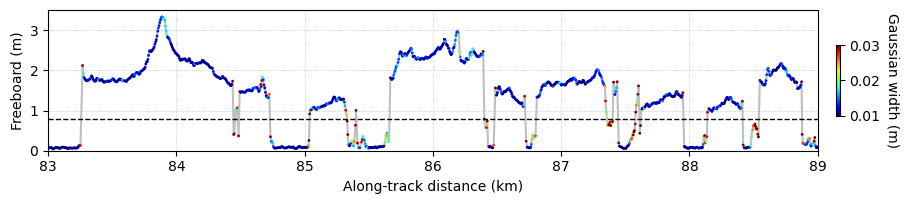

In [18]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 2), dpi = 100, sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.03, vmin = 0.01, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
# sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
cb = fig.colorbar(sc, pad = 0.02, shrink = 0.5)
cb.set_label(f"Gaussian width (m)", rotation = 270, va = "bottom")
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(0.8, ls = "--", lw = 1, c="k", zorder=2)

# ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(83, 89);

plt.show()
# plt.close()

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


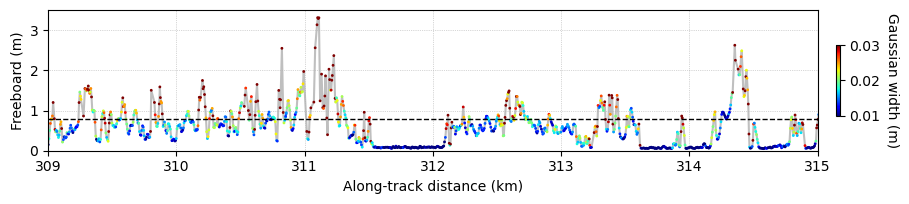

In [20]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 2), dpi = 100, sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.03, vmin = 0.01, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
# sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
cb = fig.colorbar(sc, pad = 0.02, shrink = 0.5)
cb.set_label(f"Gaussian width (m)", rotation = 270, va = "bottom")
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(0.8, ls = "--", lw = 1, c="k", zorder=2)

# ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(309, 315);

plt.show()

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


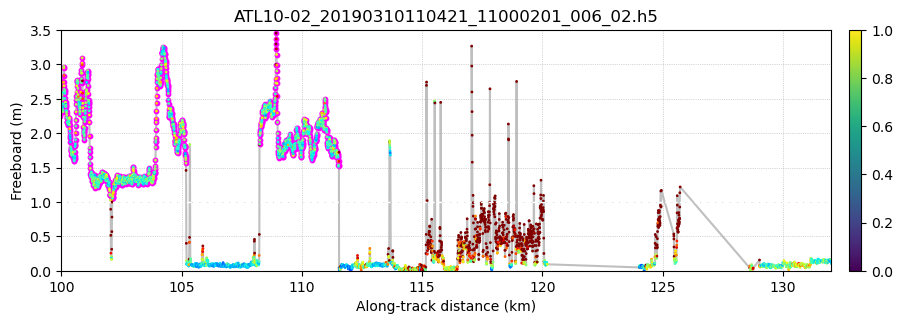

In [82]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 3), sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
fig.colorbar(sc, pad = 0.02)
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(100, 132);

plt.show()
# plt.close()